# AIRLINE PASSENGER SATISFACTION PREDICTION - PREDICTION

## Data reading and libraries importing

Let's import the necessary libraries

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
# let's read the dataset previosly downloaded

df = pd.read_csv('datasets/train.csv', index_col=0)
pd.set_option('display.max_columns', None)
df.head()

,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,1,5,3,5,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,3,1,3,1,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,2,2,5,5,5,5,4,3,4,4,4,5,0,0.0,satisfied
3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,5,5,2,2,2,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,3,3,4,5,5,3,3,4,4,3,3,3,0,0.0,satisfied


## EDA

Let's see datatypes

In [3]:
df.dtypes

id                                     int64
Gender                                object
Customer Type                         object
Age                                    int64
Type of Travel                        object
Class                                 object
Flight Distance                        int64
Inflight wifi service                  int64
Departure/Arrival time convenient      int64
Ease of Online booking                 int64
Gate location                          int64
Food and drink                         int64
Online boarding                        int64
Seat comfort                           int64
Inflight entertainment                 int64
On-board service                       int64
Leg room service                       int64
Baggage handling                       int64
Checkin service                        int64
Inflight service                       int64
Cleanliness                            int64
Departure Delay in Minutes             int64
Arrival De

In [4]:
# let's set object type as category type
for column in df.columns:
    if df[column].dtype == np.dtype('O'):
        df[column] = df[column].astype('category')

Checking duplicates

In [5]:
# let's see duplicate passengers
print(f'There are {df.shape[0]} rows and {len(df.id.drop_duplicates())} distinct passengers')

There are 103904 rows and 103904 distinct passengers


Checking missing values

In [6]:
for column in df.columns:
    if df[column].isnull().sum() > 0:
        print(f'Feature: {column} has {df[column].isnull().sum()} missing values')

Feature: Arrival Delay in Minutes has 310 missing values


Missing values imputation

In [7]:
# let's replace missing values by mean
df['Arrival Delay in Minutes'].replace(np.nan, df['Arrival Delay in Minutes'].loc[np.where(df['Arrival Delay in Minutes']>0)].mean(), inplace = True)

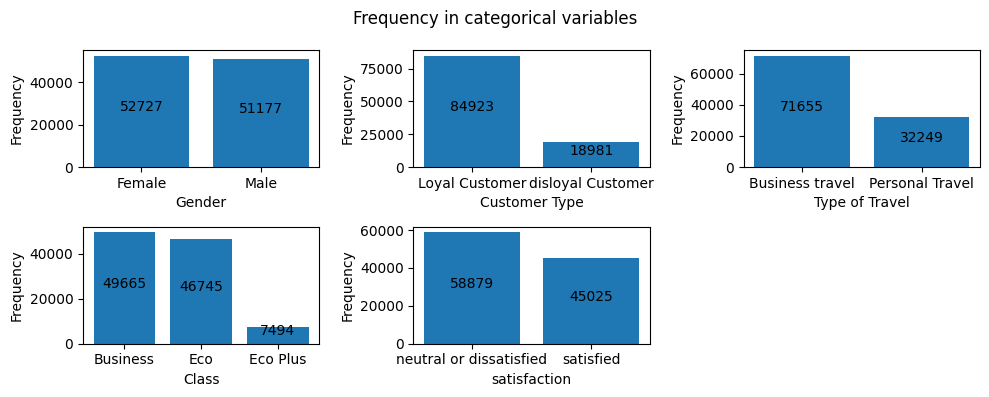

In [8]:
categorical_features = df.select_dtypes('category').columns
plt.figure(figsize=(10,4))
plot = 1

def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i]//2, y[i], ha = 'center')

for feature in categorical_features:
    plt.subplot(2,3,plot)
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    x = df[feature].value_counts().index.to_list()
    y = df[feature].value_counts().values
    plt.bar(x, y)
    addlabels(x,y)
    plot += 1


plt.suptitle('Frequency in categorical variables')
plt.tight_layout() 
plt.show()

From the previous visualization we can assume that both genders have an aproximate participation in the survey, there are more opinions from passenger who flew in business travel, and business and eco class are the most buyed ticket classes.
In adition, our target variable 'satisfaction' is about balanced.

In [9]:
satisfaction = df.groupby(['Gender', 'satisfaction']).agg({'id':'count'}).reset_index().rename(columns = {'id':'cases'})
satisfaction

,Gender,satisfaction,cases
0,Female,neutral or dissatisfied,30193
1,Female,satisfied,22534
2,Male,neutral or dissatisfied,28686
3,Male,satisfied,22491


In [10]:
a = list(categorical_features)
a.pop(4)
a

['Gender', 'Customer Type', 'Type of Travel', 'Class']

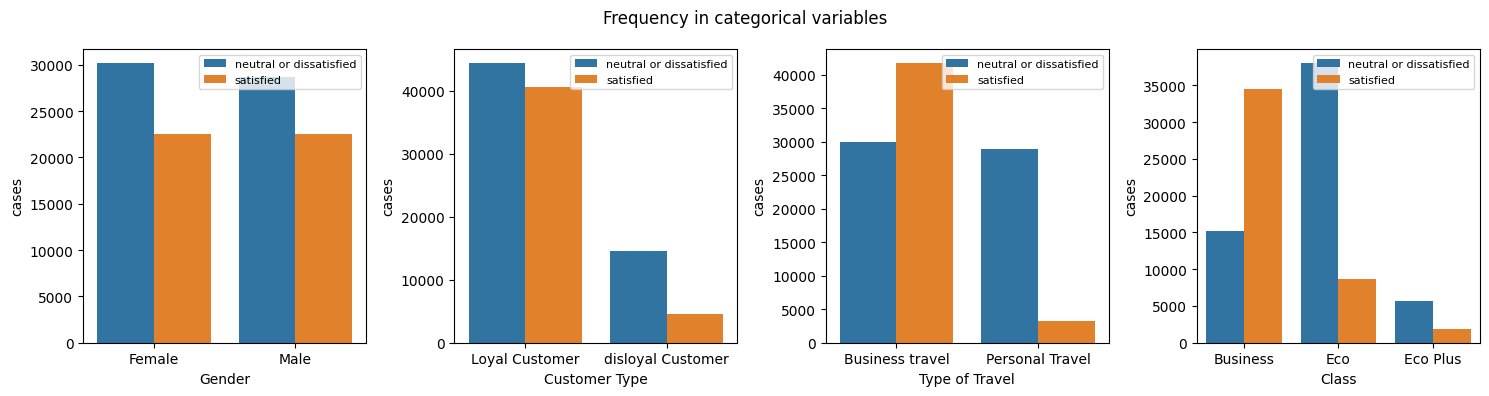

In [11]:

plt.figure(figsize=(15,4))
plot = 1
a = list(categorical_features)
a.pop(4)
a

for feature in a:
    plt.subplot(1,4,plot)
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    aux_df = df.groupby([feature, 'satisfaction']).agg({'id':'count'}).reset_index().rename(columns = {'id':'cases'})
    sns.barplot(data = aux_df, x = feature, y = 'cases', hue = 'satisfaction')
    plt.legend(loc=1, prop={'size': 8})
    plot += 1


plt.suptitle('Frequency in categorical variables')
plt.tight_layout() 
plt.show()

We can see how the satisfaction varies within all the categorical variables and them categories. Also, we can check that there aren't inconsistences in the categories of these variables, so we don't need to do a cleaning process on them.

In [12]:
# the scores of the variables that compose the surveys should be between 0 and 5, let's test it
numerical_variables = df.drop(columns = categorical_features).columns
df[numerical_variables].describe()

,id,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes
count,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000
mean,64924.210502,39.379706,1189.448375,2.729683,3.060296,2.756901,2.976883,3.202129,3.250375,3.439396,3.358158,3.382363,3.351055,3.631833,3.304290,3.640428,3.286351,14.815618,15.236646
std,37463.812252,15.114964,997.147281,1.327829,1.525075,1.398929,1.277621,1.329533,1.349509,1.319088,1.332991,1.288354,1.315605,1.180903,1.265396,1.175663,1.312273,38.230901,38.655437
min,1.000000,7.000000,31.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,32533.750000,27.000000,414.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000,0.000000,0.000000
50%,64856.500000,40.000000,843.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000,0.000000,0.000000
75%,97368.250000,51.000000,1743.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,5.000000,4.000000,5.000000,4.000000,12.000000,13.000000
max,129880.000000,85.000000,4983.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1592.000000,1584.000000


Outliers in continuous variables

<AxesSubplot: title={'center': 'Boxplot for outlier analysis'}>

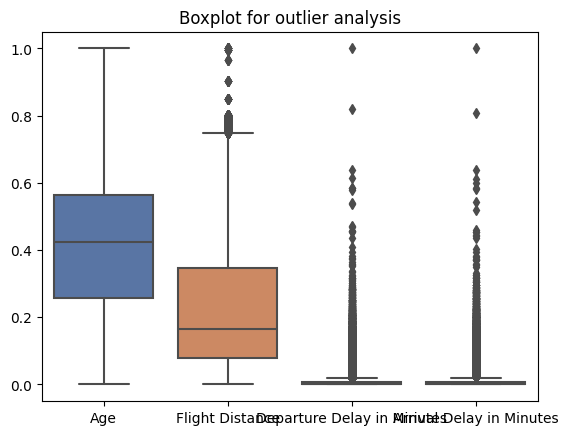

In [13]:
# Let's do a scaling process in continuous variables in order to see outliers

from sklearn.preprocessing import MinMaxScaler
plt.title('Boxplot for outlier analysis')
scaler = MinMaxScaler()
sns.set(rc={'figure.figsize':(15,3)})
sns.boxplot(data = pd.DataFrame(scaler.fit_transform(df[['Age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']]) \
    ,columns = ['Age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']))

In [14]:
# let's remove outliers from "Flight Distance", "Departure Delay in Minutes" and "Arrival Delay in Minutes" features

def remove_outliers(df, column):
    q1 = np.quantile(df[column], 0.25)
    q3 = np.quantile(df[column], 0.75)
    iqr = q3-q1
    cond1 = q1 - (1.5 * iqr)
    cond2 = q3 + (1.5 * iqr)
    median = df[column].median()
    df[column] = np.where((df[column] < cond1) | (df[column] > cond2), median, df[column] )

In [15]:
for feature in ['Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']:
    remove_outliers(df, feature)

In [16]:
# let's create a dict that contains the discretization of the satisfaction values
targets = list(df['satisfaction'].drop_duplicates().values)
target = {}
for i in range(len(targets)):
    target[i]  = targets[i]

df['target'] = df['satisfaction'].replace(dict(zip(target.values(), target.keys()))).astype('int64') # we do this to change from {0: 'neutral or dissatisfied'... to {'neutral or dissatisfied': 0 ...

In [20]:
# let's do the encoding for categorical variables
dummies = pd.get_dummies(df[categorical_features].drop(columns=['satisfaction']))
X = pd.concat([df[numerical_variables].drop(columns = ['id']), dummies], axis = 1)
y = df['target'].values.reshape(-1,1)

## Feature Selection

Let's see a correlation matrix in order to find high correlated features that could be removed

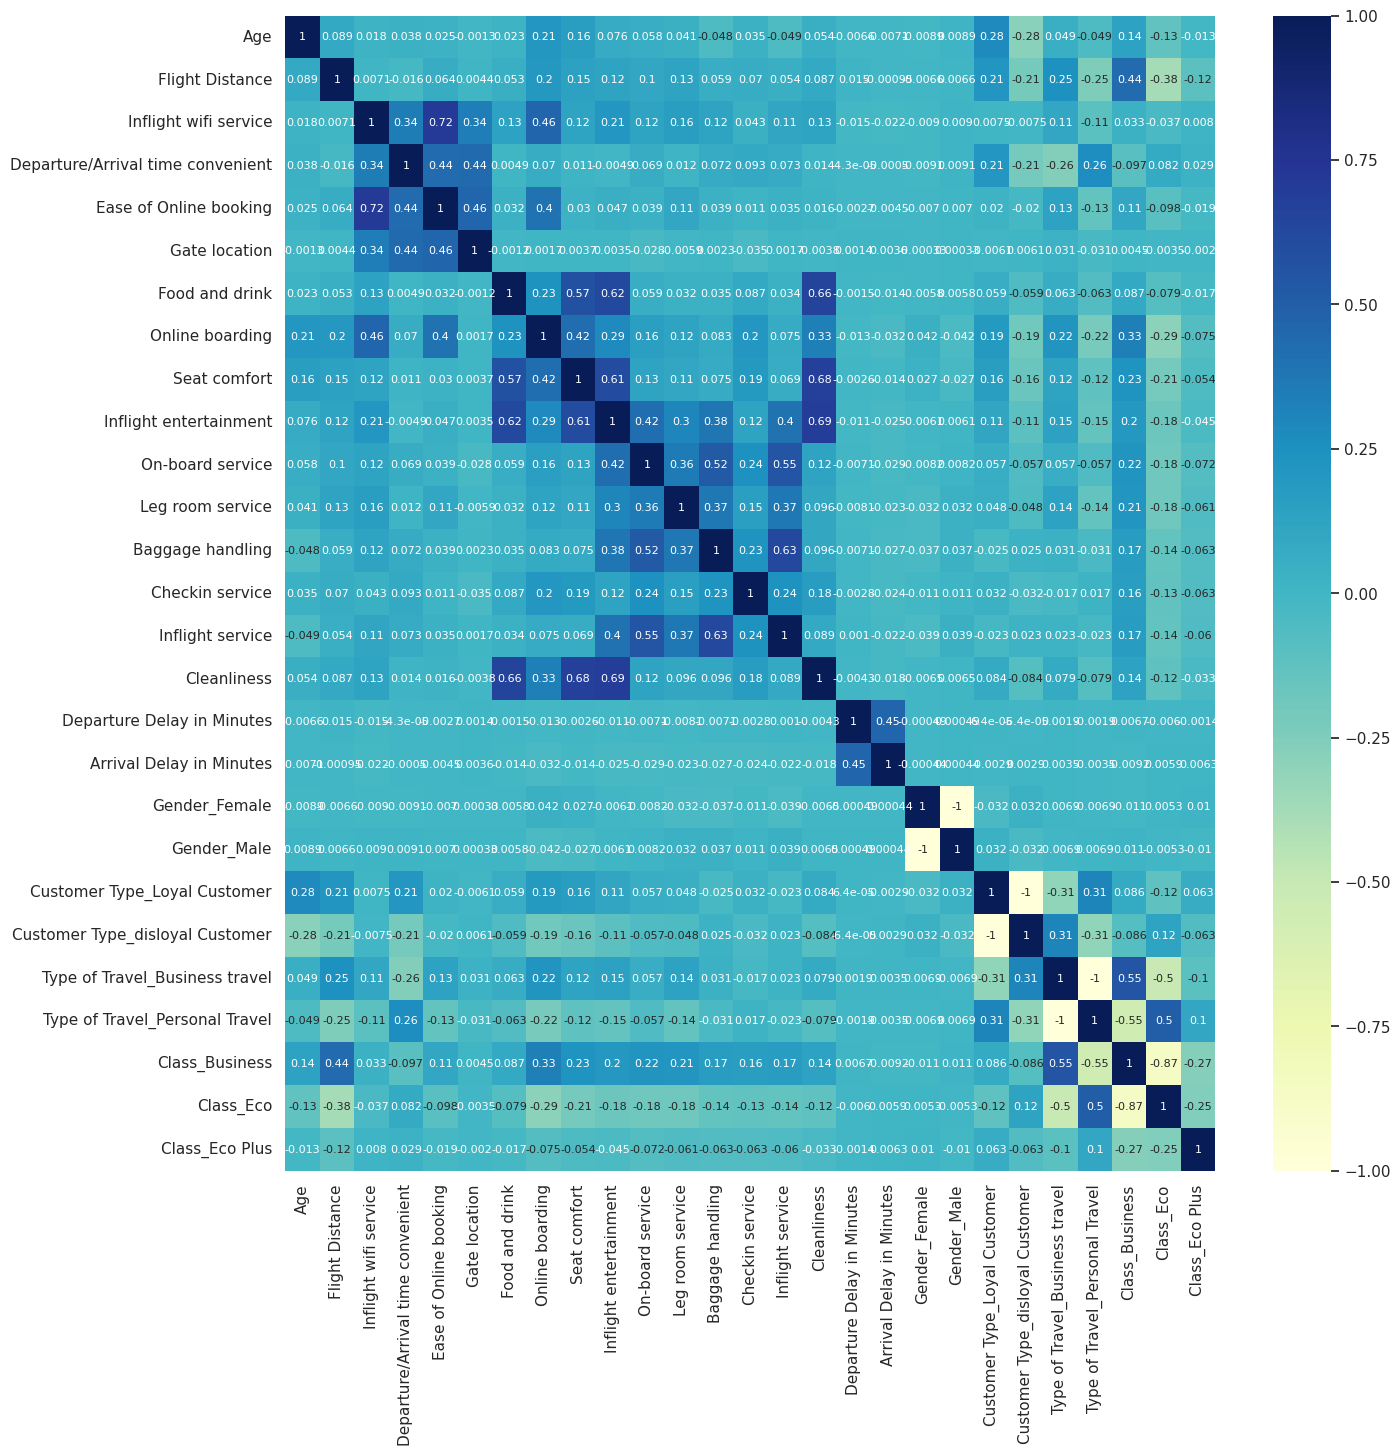

In [29]:
corr = X.corr()
sns.set(rc={'figure.figsize':(15,15)})
sns.heatmap(data = corr, annot = True, cmap = 'YlGnBu', annot_kws={"size": 8})
plt.show()

There are some correlation values higher than 0.7 that is the standard for high correlated values. So we can drop some of this features

In [31]:
X.drop(columns = ['Ease of Online booking'], inplace = True)

In [32]:
# Scaling all our variables

X = pd.DataFrame(scaler.fit_transform(X), columns = X.columns)

## Splitting training data into train and test

We already know that the file previously downloaded has 2 .csv, train and test. We are going to train and test with train.csv and then test again with test.csv

In [37]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 15, test_size=0.2)
print(f'X_train shape: {X_train.shape}, y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}, y_test shape: {y_test.shape}')

X_train shape: (83123, 26), y_train shape: (83123, 1)
X_test shape: (20781, 26), y_test shape: (20781, 1)
